In [1]:
from numpy import zeros, array
from functools import lru_cache
from math import log
from tqdm import tqdm

from random import randint as rint
from random import seed, shuffle
seed(42)

import pandas as pd
import pymorphy2
morph = pymorphy2.MorphAnalyzer()
import time
import re

import matplotlib.pyplot as plt

In [2]:
class Node(object):
    def __init__(self, value, child=None, key=None, end=False):
        if child is not None and key is not None:
            self.children = {key: child}
        else:
            self.children = {}
        self.value = value
        self._isEnd = end

    def __str__(self):
        return f"keys = {list(self.children.keys())}, value = {self.value}, \
end = {self._isEnd}"

    def addChild(self, value, key):
        self.children[key] = Node(value)

    def hasChild(self, key):
        if key in self.children.keys():
            return True
        return False

    def getChild(self, key):
        return self.children[key]

    def setValue(self, value):
        self.value = value

    def getValue(self):
        return self.value

    def isEnd(self):
        return self._isEnd

    def getKeys(self):
        return list(self.children.keys())

    def setEnd(self):
        self._isEnd = True


class PrefixTrie(object):
    def __init__(self, db=None):
        self.root = Node('')

        if db is not None:
            for word in db:
                self.insert(word, word)

    def insertDict(self, db_form, db_lemma):
        for i in range(len(db_form)):
            self.insert(db_form[i], db_lemma[i])

    def insert(self, key, value):
        node = self.root
        lenght_key = len(key)
        way = ""

        for i in range(lenght_key):
            char = key[i]
            way += char
            if not node.hasChild(char):
                node.addChild(way, char)
            node = node.getChild(char)
        if (not node.isEnd()):
            node.setValue(value)
            node.setEnd()

    def hasKey(self, key):
        node = self.root

        for i in range(len(key)):
            char = key[i]
            if node.hasChild(char):
                node = node.getChild(char)
            else:
                return False

        if node.isEnd():
            return True
        return False

    def largestPrefix(self, key):
        node = self.root
        lemma = ""
        lenght_key = len(key)

        for i in range(lenght_key):
            char = key[i]
            if not node.hasChild(char):
                break
            node = node.getChild(char)
            if node.isEnd():
                lemma = node.getValue()

        dif = lenght_key - len(lemma)
        if dif != 0:
            depth = 1
            stack = [node.getChild(i) for i in node.getKeys()]
            next_stack = []

            while depth <= max(dif, int(lenght_key / 2)):
                for elem in stack:
                    if elem.isEnd():
                        return elem.getValue()
                    next_stack += [elem.getChild(i) for i in elem.getKeys()]

                stack = next_stack.copy()
                next_stack = []
                depth += 1

        return lemma if lemma != "" else key

    @lru_cache
    def getLemma(self, word):
        prefix = ""
        lemma = word
        len_word = len(word)
        min_dist = len_word

        for i in range(len_word):
            prefix += word[i]
            new_lemma = self.largestPrefix(prefix)
            dist = lev_dist(new_lemma, word)

            if dist < min_dist and dist < len_word:
                if dist == 0:
                    return new_lemma
                lemma = new_lemma
                min_dist = dist

        return lemma

In [3]:
lemma_dict = pd.read_csv('C:\\Python programs\\ru_dict_lemma.csv')
print(lemma_dict)

         lemma
0            а
1           аа
2          а-а
3          ааа
4        а-а-а
...        ...
51728  ящерица
51729   ящерка
51730     ящик
51731   ящичек
51732     ящур

[51733 rows x 1 columns]


In [4]:
df_train = pd.read_csv('C:\\Python programs\\dataset_ru_word_lemma2.csv')
print(df_train)

               form          lemma  id_sen
0                 «              «     0.0
1              Если           если     0.0
2          передача       передача     0.0
3          цифровых       цифровой     0.0
4        технологий     технология     0.0
...             ...            ...     ...
19350  провозглашал  провозглашать   999.0
19351          себя           себя   999.0
19352        другом           друг   999.0
19353          мира            мир   999.0
19354             .              .   999.0

[19355 rows x 3 columns]


In [5]:
df_train2 = pd.read_csv('C:\\Python programs\\dataset_ru_word_lemma3.csv')
print(df_train2)

           form     lemma part_of_speech  id_sen
0      Алгоритм  алгоритм           NOUN     0.0
1             ,         ,          PUNCT     0.0
2            от        от            ADP     0.0
3         имени       имя           NOUN     0.0
4       учёного    ученый           NOUN     0.0
...         ...       ...            ...     ...
41428         ,         ,          PUNCT  1999.0
41429         а         а          CCONJ  1999.0
41430        от        от            ADP  1999.0
41431    тройни    тройня           NOUN  1999.0
41432         .         .          PUNCT  1999.0

[41433 rows x 4 columns]


In [6]:
df_stopwords = pd.read_csv('C:\\Python programs\\stopwords_ru.csv')
print(df_stopwords)

            stopword
0                  а
1          абсолютно
2     авторизоваться
3           активный
4               алло
...              ...
1367               „
1368               “
1369               …
1370               /
1371             ...

[1372 rows x 1 columns]


In [7]:
@lru_cache
def lev_dist(w1, w2):
    n, m = len(w1), len(w2)
    mat = zeros([n + 1, m + 1], int)
    mat[0, :] = array([i for i in range(m + 1)])
    mat[:, 0] = array([i for i in range(n + 1)])

    for i in range(1, n + 1):
        for j in range(1, m + 1):
            mat[i][j] = min(mat[i - 1][j] + 1, mat[i][j - 1] + 1,
                            mat[i - 1][j - 1] + (w1[i - 1] != w2[j - 1]))
    return mat[n][m]

In [8]:
def lemma_lev(w):
    lemma = ""
    len_w = len(w)
    len_lemma = len_w
    for word in lemma_dict["lemma"]:
        if abs(len_w - len(word)) >= len_lemma:
            continue

        word = word.lower()
        dist = lev_dist(word, w)
        if dist < len_lemma:
            if dist == 0:
                return word
            lemma = word
            len_lemma = dist

    return lemma if lemma != "" else w

In [9]:
def test_metric(metric, cnt_test=100):
    df_train = df_train2
    cnt_test = min(cnt_test, len(df_train.index))
    acc = 0
    num_reg_exp = r'[-+]?(?:\d+(?:\.\d*)?|\.\d+)(?:[eE][-+]?\d+)?'

    trie_st = PrefixTrie(df_stopwords['stopword'])
    trie = PrefixTrie(lemma_dict["lemma"].apply(str.lower))

    test_word, test_lemms, test_upos = [], [], []
    rand_idx = list(df_train.index)
    shuffle(rand_idx)

    pos_res = []
    neg_res = []

    for i in rand_idx:
        word = df_train['form'][i].lower()
        lemma = df_train['lemma'][i].lower()
        part_of_speech = df_train['part_of_speech'][i]
        if trie_st.hasKey(word) or trie_st.hasKey(lemma) or re.fullmatch(num_reg_exp, word) is not None or not trie.hasKey(lemma) or part_of_speech in [None, 'X']:
            continue

        test_word += [word]
        test_lemms += [lemma]
        test_upos += [part_of_speech]

        if len(test_word) == cnt_test:
            break

    cnt_test = len(test_word)

    with tqdm(total=cnt_test, position=0, leave=True) as pbar:
        for word, ans_lemma, part in zip(test_word, test_lemms, test_upos):

            ans = metric(word)
            if ans == ans_lemma:
                acc += 1
                pos_res += [(word, part)]
            else:
                neg_res += [(word, part)]

            pbar.set_description(f"Word: {word}, Lemma: {ans_lemma}, Ans: {ans}")
            pbar.update()

    print(acc / cnt_test)

    return (acc / cnt_test, pos_res, neg_res)

In [10]:
def print_res_part(res, title):
    acc, pos_res, neg_res = res
    pos_classes = {}
    neg_classes = {}

    for i in pos_res:
        if i[1] not in pos_classes.keys():
            pos_classes[i[1]] = 1
        else:
            pos_classes[i[1]] += 1

    for i in neg_res:
        if i[1] not in neg_classes.keys():
            neg_classes[i[1]] = 1
        else:
            neg_classes[i[1]] += 1

    res_pos = {}
    res_neg = {}
    for i in pos_classes.keys():
        if i in neg_classes.keys():
            res_pos[i] = pos_classes[i] / (pos_classes[i] + neg_classes[i]) * 100
            res_neg[i] = 100 - res_pos[i]

    width = 1
    pos = 0
    plt.subplots(figsize=(9, 6))
    plt.bar(pos, 0, 0, color='red', label='correct')
    plt.bar(pos, 0, 0, color='blue', label='invalid')
    names = {}

    for key in res_pos.keys():
        names[key] = pos
        plt.bar(pos, res_pos[key], width, bottom=0, color='red')
        plt.bar(pos, res_neg[key], width, bottom=res_pos[key], color='blue')
        pos += 3 * width

    plt.xticks(tuple(names.values()), tuple(names.keys()))
    plt.ylabel("percentages")
    plt.legend(ncols=2)
    plt.title(title)
    plt.grid(axis='y')

    plt.savefig(f'C:\\Users\\user\\Desktop\\NLP_foto\\{title.split()[0]}_part.png')

    plt.show()

In [11]:
def print_res_len(res, title):
    acc, pos_res, neg_res = res
    pos_classes = {}
    neg_classes = {}

    for i in pos_res:
        len_word = len(i[0])
        if len_word not in pos_classes.keys():
            pos_classes[len_word] = 1
        else:
            pos_classes[len_word] += 1

    for i in neg_res:
        len_word = len(i[0])
        if len_word not in neg_classes.keys():
            neg_classes[len_word] = 1
        else:
            neg_classes[len_word] += 1

    res_pos = {}
    res_neg = {}
    for i in pos_classes.keys():
        if i in neg_classes.keys():
            res_pos[i] = pos_classes[i] / (pos_classes[i] + neg_classes[i]) * 100
            res_neg[i] = 100 - res_pos[i]

    res_pos = dict(sorted(res_pos.items()))
    res_neg = dict(sorted(res_neg.items()))

    width = 1
    pos = 0
    plt.subplots(figsize=(9, 6))
    plt.bar(pos, 0, 0, color='red', label='correct')
    plt.bar(pos, 0, 0, color='blue', label='invalid')
    pos_log = []

    for key in res_pos.keys():
        pos_log += [pos]
        plt.bar(pos, res_pos[key], width, bottom=0, color='red')
        plt.bar(pos, res_neg[key], width, bottom=res_pos[key], color='blue')
        pos += 3 * width

    plt.ylabel("percentages")
    plt.xlabel("length of word")
    plt.xticks(pos_log, tuple(res_pos.keys()))
    plt.legend(ncols=2)
    plt.title(title)
    plt.grid(axis='y')

    plt.savefig(f'C:\\Users\\user\\Desktop\\NLP_foto\\{title.split()[0]}_len.png')

    plt.show()

In [12]:
def jaro_dist(w1, w2):
    len_w1, len_w2 = len(w1), len(w2)
    blok = max(len_w1, len_w2) // 2 - 1
    tr = 0
    m = 0

    for i in range(len_w1):
        char1 = w1[i]
        for j in range(len_w2):
            if abs(i - j) <= blok:
                if w2[j] == char1:
                    m += 1
                    if i != j:
                        tr += 1
                    break
    tr //= 2
    return 0 if m == 0 else 1/3 * (m / len_w1 + m / len_w2 + (m - tr) / m)

In [13]:
def jaro_vin_dist(w1, w2, max_ll, p, b):
    len_w1, len_w2 = len(w1), len(w2)
    blok = max(len_w1, len_w2) // 2 - 1
    tr = 0
    m = 0
    ll = 0
    d = 0

    for i in range(min(len_w1, len_w2)):
        if w2[i] == w1[i]:
            ll += 1
        else:
            break

    for i in range(ll, len_w1):
        char1 = w1[i]
        for j in range(ll, len_w2):
            if abs(i - j) <= blok:
                if w2[j] == char1:
                    m += 1
                    if i != j:
                        tr += 1
                    break

    m += ll
    ll = min(ll, max_ll)

    if m != 0:
        d = min(1/3 * (m / len_w1 + m / len_w2 + (m - tr) / m), 1)

    return d + ll * p * (1 - d) if d > b else d

In [14]:
def lemma_jaro(w):
    lemma = w
    len_w = len(w)
    max_dist = 0
    for word in lemma_dict["lemma"]:
        word = word.lower()
        if abs(len_w - len(word)) >= len_w:
            continue

        dist = jaro_dist(word, w)
        if dist > max_dist and dist <= 1:
            if dist == 1:
                return word
            lemma = word
            max_dist = dist

    return lemma

In [15]:
def lemma_jaro_vin(w, max_ll=4, p=0.2, b=0.7):
    lemma = w
    len_w = len(w)
    max_dist = 0
    for word in lemma_dict["lemma"]:
        word = word.lower()
        if abs(len_w - len(word)) >= len_w:
            continue

        dist = jaro_vin_dist(word, w, max_ll=max_ll, p=p, b=b)
        if dist > max_dist and dist <= 1:
            if dist == 1:
                return word
            lemma = word
            max_dist = dist

    return lemma

In [16]:
lemma_jaro('гнездился')

'гнездиться'

In [17]:
trie = PrefixTrie(lemma_dict["lemma"].apply(str.lower))

In [18]:
@lru_cache
def lemma_dbsra(w):
    lemma = ""
    for i in range(len(w)):
        for j in range(len(w), i, -1):
            if trie.hasKey(w[i:j]) and j - i > len(lemma):
                lemma = w[i:j]
    return lemma if lemma != "" else w

In [23]:
def damerau_levenshtein_distance(s1, s2):
    d = {}
    lenstr1 = len(s1)
    lenstr2 = len(s2)
    for i in range(-1, lenstr1+1):
        d[(i, -1)] = i + 1
    for j in range(-1, lenstr2+1):
        d[(-1, j)] = j + 1

    for i in range(lenstr1):
        for j in range(lenstr2):
            if s1[i] == s2[j]:
                cost = 0
            else:
                cost = 1
            d[(i, j)] = min(
                           d[(i-1, j)] + 1,  # deletion
                           d[(i, j-1)] + 1,  # insertion
                           d[(i-1, j-1)] + cost,  # substitution
                          )
            if i and j and s1[i] == s2[j-1] and s1[i-1] == s2[j]:
                d[(i, j)] = min(d[(i, j)], d[i-2, j-2] + 1)  # transposition

    return d[lenstr1-1, lenstr2-1]

In [34]:
def lemma_framework_PT_DBSRA(w):
    
    lemma_PT = trie.getLemma(w)
    lemma_DBSRA = lemma_dbsra(w)
    
    if lemma_PT == lemma_DBSRA:
        return lemma_PT
    
    dist_PT = jaro_vin_dist(lemma_PT, w, 1, 0.9, 0.7)
    dist_DBSRA = jaro_vin_dist(lemma_DBSRA, w, 1, 0.9, 0.7)
    
    if dist_PT < dist_DBSRA:
        lemma = lemma_DBSRA
    else:
        lemma = lemma_PT
        
    if max(dist_PT, dist_DBSRA) < 0.7:
        return w
    
    return lemma

In [20]:
def lemma_lev_dam(w):
    lemma = w
    len_w = len(w)
    min_dist = len_w
    for word in lemma_dict["lemma"]:
        word = word.lower()
        if abs(len_w - len(word)) >= len_w:
            continue

        dist = damerau_levenshtein_distance(word, w)
        if dist < min_dist:
            if dist == 0:
                return word
            lemma = word
            min_dist = dist

    return lemma

In [ ]:
hist = test_metric(lambda x: lemma_jaro_vin(x, 2, 0.4, 0.7), 1000)
print_res_part(hist, "Jaro–Winkler distance")
print_res_len(hist, "Jaro–Winkler distance")
# 0.764

In [ ]:
hist = test_metric(lambda x: lemma_jaro_vin(x, 1, 0.9, 0.7), 1000)
print_res_part(hist, "Jaro–Winkler distance")
print_res_len(hist, "Jaro–Winkler distance")
# 0.783

In [ ]:
hist = test_metric(lambda x: lemma_jaro_vin(x, 4, 0.2, 0.7), 1000)
print_res_part(hist, "Jaro–Winkler distance")
print_res_len(hist, "Jaro–Winkler distance")
# 0.762

In [ ]:
hist = test_metric(lemma_jaro, 1000)
print_res_part(hist, "Jaro distance")
print_res_len(hist, "Jaro distance")
# 0.595

In [ ]:
hist = test_metric(lemma_lev, 1000)
print_res_part(hist, "Levenshtein distance")
print_res_len(hist, "Levenshtein distance")
# 0.750

Word: проехалась, Lemma: проехаться, Ans: проехать: 100%|███████████████████████| 10000/10000 [00:30<00:00, 330.46it/s]


0.773


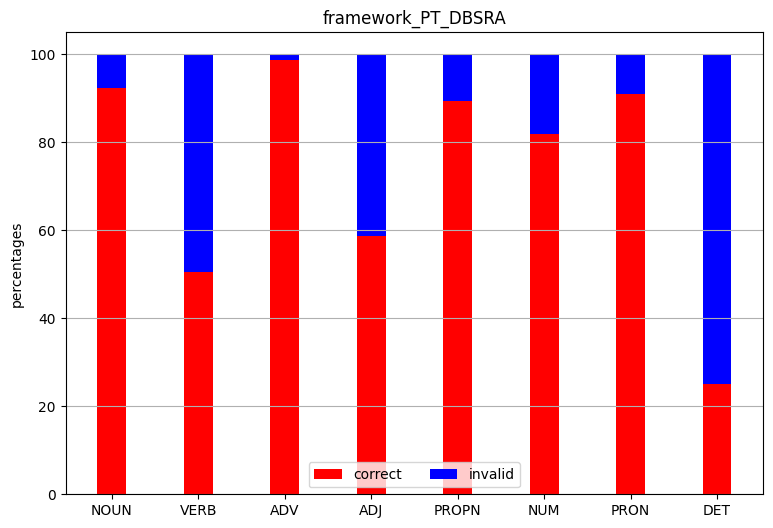

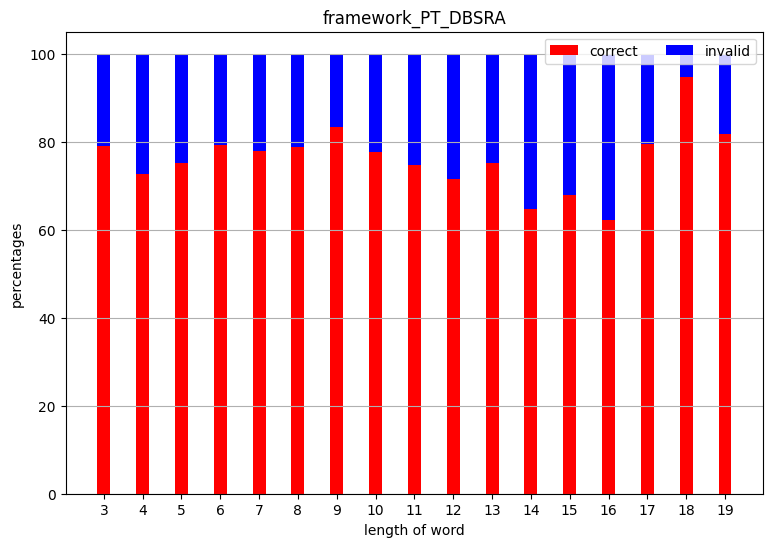

In [35]:
hist = test_metric(lemma_framework_PT_DBSRA, 10000)
print_res_part(hist, "framework_PT_DBSRA")
print_res_len(hist, "framework_PT_DBSRA")
# 0.750

Word: маршрут, Lemma: маршрут, Ans: маршрут: 100%|██████████████████████████████| 10000/10000 [00:21<00:00, 467.43it/s]


0.9291


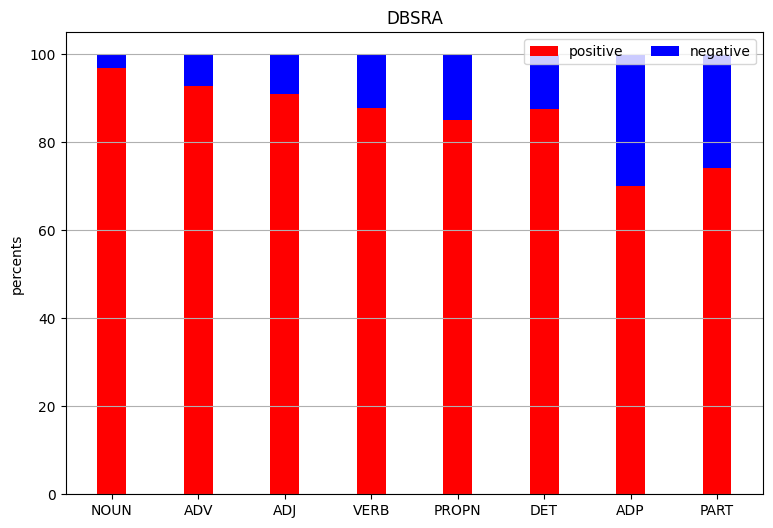

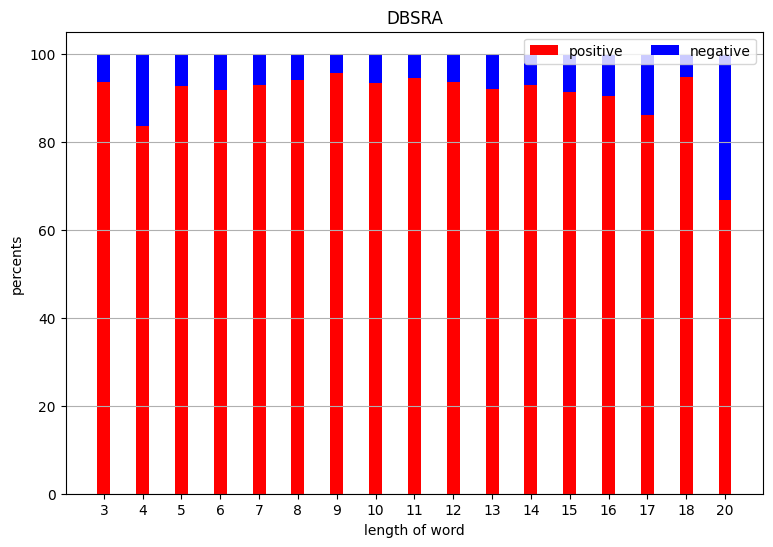

In [118]:
hist = test_metric(lambda x: morph.parse(x)[0].normal_form, 10000)
print_res_part(hist, "DBSRA")
print_res_len(hist, "DBSRA")
# lambda x: morph.parse(x)[0].normal_form: 0.931 +
# trie.getLemma: 0.790 +
# lemma_jaro_vin: 0.752 p=0.4, b=0.7, l=2 +
# lemma_jaro_vin: 0.750 p=0.9, b=0.7, l=1 +
# lemma_jaro_vin: 0.788 p=0.2, b=0.7, l=4
# lemma_jaro_vin: 0.786 p=0.4, b=0.8, l=2
# lemma_jaro_vin: 0.782 p=0.4, b=0.6, l=2
# lemma_lev: 0.769
# lemma_lev_dam: 0.740
# lemma_jaro: 0.584
# lemma_dbsra: 0.409 +
# lambda x: x: 0.263 +